# Figure 7a-c

This notebook generates the model construction schematics, as well as the simulated examples shown in Figure 7.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
import os
import matplotlib.pyplot as plt
import matplotlib as mpl

from phase_precession_model import PhasePrecessionModel, \
                                   PhasePrecessionModelSimulator, \
                                   CircularLinearRegressor

from numpy import pi
from pprint import pprint
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams["font.family"] = "Arial"



In [2]:
from utils import hex2rgb, heaviside, sigstars, place_regression_line, rootpth


In [3]:

def setup(experiment):
    """Wrapper to generate a phase precession model with the predetermined (hardcoded) parameters.
    
    Takes in only the experiment name. Treat this not as a function per se*
    but more like a dictionary.
    
    * by that I mean it's not general enough to be re-used in the
    traditional sense that functions are good for.
    It's also sharing variable scopes which can be unsafe."""

    A_inh   = {'control': A_control, 'dglesion': A_control, 'meclesion': A_mec}
    phi_inh = {'control': phi_control,  'dglesion': phi_dg, 'meclesion': phi_control}
    # A_inh   = {'control': 3, 'dglesion': 3, 'meclesion': 1}
    # phi_inh = {'control': -20,  'dglesion': -90, 'meclesion': -20}
    psi = -30

    model = PhasePrecessionModel(A_inh[experiment], np.deg2rad(phi_inh[experiment]), noise_scale=2,dc_comp=0.0, device='cpu')
    model.psi_(np.deg2rad(psi))
    if experiment == 'dglesion':
        model._DG.amplitude = 0
    elif experiment == 'meclesion':
        model._MEC.amplitude = 0
    simulator = PhasePrecessionModelSimulator(model, n_points=1000, device='cpu')
    print('setup, psi='+str(psi)+', A='+str(A_control)+', phi='+ str(phi_control))
    
    return simulator, model


In [8]:
saveFigsTo = 'figures/'

# Model Construction

Enter the desired parameters for the models (control, dg lesion, mec lesion) here. These are shared with the function `setup`.

In [5]:
psi = -30
A_inh = 2.5
phi_inh = 320
dc_comp = 0.0

model = PhasePrecessionModel(A_inh, np.deg2rad(phi_inh), dc_comp=dc_comp, device='cpu', noise_scale=0.2)
model.psi_(np.deg2rad(psi))


## Computation of the individual elements, combination of elements, total drive, and simulated spike phase-distance values for later plotting

In [6]:
x = torch.linspace(0,1,1001)

# Curves to plot (inputs and envelopes)
dg = model._DG.total_spiking_drive(x)
dg_env = model._DG.spatial_modul(x)
mec = model._MEC.total_spiking_drive(x)
mec_env = model._MEC.spatial_modul(x)
inh = model._INH.total_spiking_drive(x)
spiking = model.TotalDrive(x)
lfp = model.LFP_theta(x)
noisetrace = model._membrane_noise.sample_n(len(x))


n_trains, firing_rate = 20, 20
simulator = PhasePrecessionModelSimulator(model, n_points=1000, device='cpu')
spike_times, spike_phases, valid = simulator.simulate(n_trains, firing_rate)


regressor = CircularLinearRegressor(spike_times[valid].unsqueeze(0), 
                                    spike_phases[valid].unsqueeze(0), 
                                    [-2, 2], 
                                    n_optimization_steps=200, 
                                    optimizer_step_size=3e-2
                                   )
regressor_single = CircularLinearRegressor(spike_times[0][valid[0]].unsqueeze(0), 
                                    spike_phases[0][valid[0]].unsqueeze(0), 
                                    [-2, 2], 
                                    n_optimization_steps=200, 
                                    optimizer_step_size=3e-2
                                   )
slope, phi_on, rho, tavl, pval, _ = regressor.regresscl()
slope_single, phi_on_single, rho_single, tavl_single, pval_single, _ = regressor_single.regresscl()

distance = np.c_[spike_times[valid].cpu(), spike_times[valid].cpu()]
phase = np.c_[spike_phases[valid].cpu(), 2*pi+spike_phases[valid].cpu()]
distance_single = np.c_[spike_times[0][valid[0]].cpu(), spike_times[0][valid[0]].cpu()]
phase_single = np.c_[spike_phases[0][valid[0]].cpu(), 2*pi+spike_phases[0][valid[0]].cpu()]
m_single, M_single = min(distance.ravel()), max(distance.ravel())


COLORS = {'dgc': hex2rgb("7DADCC"),
          'inh': hex2rgb("59B9B6"),
          'mecc': hex2rgb("E3B768"),
          'mecx': hex2rgb("E3B768")}

all_sides = ['top', 'right', 'left', 'bottom']


/opt/anaconda3/envs/Sia/lib/python3.11/site-packages/torch/distributions/distribution.py:173: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


Optimization: done 100 steps in 0.161 s.
	Forward pass: 0.078s.
	Backward pass: 0.069s.
	Param updates: 0.012s.
Optimization: done 200 steps in 0.238 s.
	Forward pass: 0.035s.
	Backward pass: 0.030s.
	Param updates: 0.010s.
Optimization: done 100 steps in 0.029 s.
	Forward pass: 0.009s.
	Backward pass: 0.013s.
	Param updates: 0.005s.
Optimization: done 200 steps in 0.068 s.
	Forward pass: 0.013s.
	Backward pass: 0.017s.
	Param updates: 0.007s.


## Elements of the model

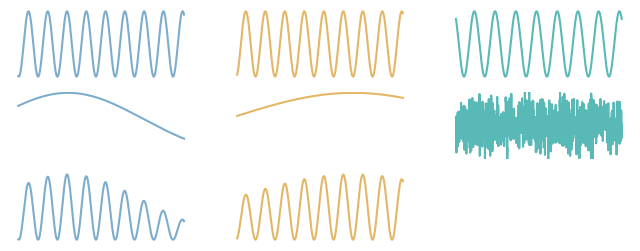

In [9]:
fig, ax = plt.subplots(3,3, figsize=(8,3))

ax[0,0].plot(x, dg , color=COLORS['dgc'])
ax[0,1].plot(x, mec, color=COLORS['mecc'])
ax[0,2].plot(x, inh/A_inh, color=COLORS['inh'])


ax[1,0].plot(x, dg_env, color=COLORS['dgc'])
ax[1,1].plot(x, mec_env, color=COLORS['mecc'])
ax[1,2].plot(x, .5+noisetrace, color=COLORS['inh'])

ax[2,0].plot(x, dg * dg_env, color=COLORS['dgc'])
ax[2,1].plot(x, mec * mec_env, color=COLORS['mecc'])

[ax.spines[all_sides].set_visible(False) for ax in ax.flatten()];
[ax.set_xticks([]) for ax in ax.flatten()];
[ax.set_yticks([]) for ax in ax.flatten()];
[ax.set_ylim([-0.02, 1+.02]) for ax in ax.flatten()];
#ax[1,2].set_ylim([-1,1])

plt.savefig(os.path.join(saveFigsTo, 'construction.pdf'), bbox_inches='tight')


## Visualized calculation of (rectified) total drive

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

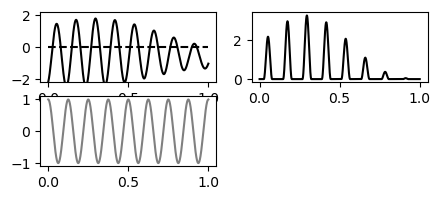

In [10]:
fig, ax = plt.subplots(2,2, figsize=(5,2))

ax[0,0].plot(x, dg*dg_env + mec*mec_env - inh - dc_comp, color='k')
ax[0,1].plot(x, heaviside(dg*dg_env + mec*mec_env - inh - dc_comp) ** 2, color='k')
ax[0,0].plot([0,1],[0]*2,'--k')
ax[0,0].set_ylim([-2.2, 2.2])
ax[1,1].remove()

ax[1,0].plot(x, lfp, 'gray')

plt.savefig(os.path.join(saveFigsTo, 'construction2.pdf'), bbox_inches='tight')


# The model can generate phase precession on single passes

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

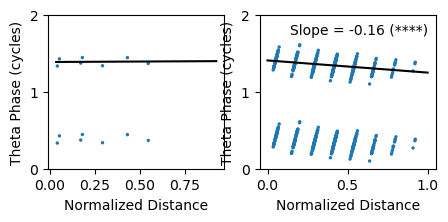

In [11]:
# m_single, M_single = 0, 1
m, M = 0, 1

_, ax = plt.subplots(1,2,figsize=(5,2))
ax[0].scatter(distance_single, phase_single, s=6, ec='none')
Y_single = place_regression_line(slope_single, phi_on_single, m_single, M_single, ax[0])
# ax[0].text(M_single, pi+Y_single[:, -1], f'Slope = {slope_single[-1]:.2f} ({sigstars(pval_single)})', ha='right')

ax[1].scatter(distance, phase, s=6, ec='none')
Y = place_regression_line(slope, phi_on, m, M, ax[1])
ax[1].text(M, pi+Y[:, -1], f'Slope = {slope[-1]:.2f} ({sigstars(pval)})', ha='right')

plt.savefig(os.path.join(saveFigsTo, 'construction_example_control.pdf'), bbox_inches='tight')


# Small phase difference leads to different interference patterns within the simulated place field

Although the phase difference is relatively small between the excitatory and inhibitory inputs (8.5, 8.6 for excitatory and 8 for inhibitory), the net effect over the length of the simulated place field is that inhibition will destroy the excitation later in the field, given certain choices of phase offset $\phi_{\textrm{inh}}$.

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

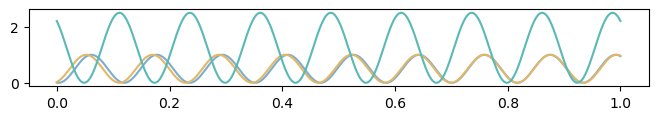

In [12]:
fig, ax = plt.subplots(1,1, figsize=(8,1))

ax.plot(x, dg , color=COLORS['dgc'])
ax.plot(x, mec, color=COLORS['mecc'])
ax.plot(x, inh, color=COLORS['inh'])

# [ax.spines[all_sides].set_visible(False) for ax in ax];

# plt.savefig(os.path.join(saveFigsTo, 'construction_inputs.pdf'), bbox_inches='tight')



# Examples for Figure 7

In [13]:

firing_rate = 20
n_trains = 1
A_control = 2.5
phi_control = 320
A_mec = 2.5
phi_dg = 320

Single trial examples

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


setup, psi=-30, A=2.5, phi=320
Optimization: done 100 steps in 0.043 s.
	Forward pass: 0.014s.
	Backward pass: 0.018s.
	Param updates: 0.008s.
Optimization: done 200 steps in 0.088 s.
	Forward pass: 0.015s.
	Backward pass: 0.019s.
	Param updates: 0.008s.
pvalue = 0.6826828695119639


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

setup, psi=-30, A=2.5, phi=320
Optimization: done 100 steps in 0.056 s.
	Forward pass: 0.019s.
	Backward pass: 0.023s.
	Param updates: 0.010s.
Optimization: done 200 steps in 0.093 s.
	Forward pass: 0.013s.
	Backward pass: 0.016s.
	Param updates: 0.006s.
pvalue = 0.9012227009494667


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

setup, psi=-30, A=2.5, phi=320
Optimization: done 100 steps in 0.033 s.
	Forward pass: 0.011s.
	Backward pass: 0.014s.
	Param updates: 0.005s.
Optimization: done 200 steps in 0.063 s.
	Forward pass: 0.010s.
	Backward pass: 0.013s.
	Param updates: 0.005s.
pvalue = 0.41709495885343106


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

setup, psi=-30, A=2.5, phi=320
Optimization: done 100 steps in 0.043 s.
	Forward pass: 0.015s.
	Backward pass: 0.018s.
	Param updates: 0.008s.
Optimization: done 200 steps in 0.074 s.
	Forward pass: 0.011s.
	Backward pass: 0.014s.
	Param updates: 0.005s.
pvalue = 0.1860359954850559


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

setup, psi=-30, A=2.5, phi=320
Optimization: done 100 steps in 0.046 s.
	Forward pass: 0.016s.
	Backward pass: 0.019s.
	Param updates: 0.008s.
Optimization: done 200 steps in 0.077 s.
	Forward pass: 0.011s.
	Backward pass: 0.014s.
	Param updates: 0.005s.
pvalue = 0.07793039353687192


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

setup, psi=-30, A=2.5, phi=320
Optimization: done 100 steps in 0.040 s.
	Forward pass: 0.014s.
	Backward pass: 0.017s.
	Param updates: 0.007s.
Optimization: done 200 steps in 0.074 s.
	Forward pass: 0.012s.
	Backward pass: 0.015s.
	Param updates: 0.006s.
pvalue = 0.02263134370438813


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

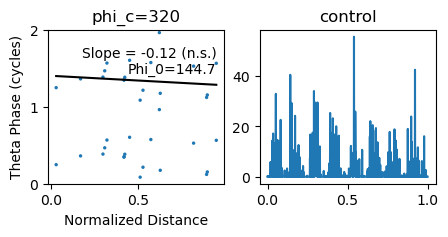

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

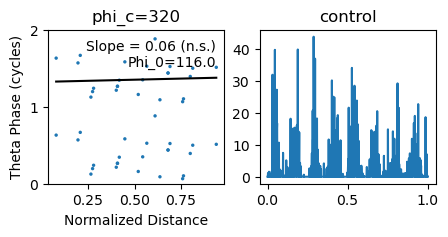

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

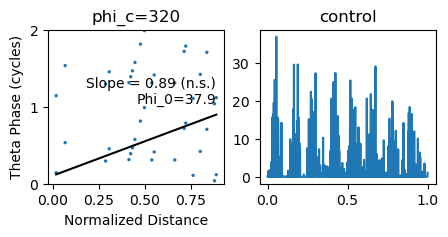

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

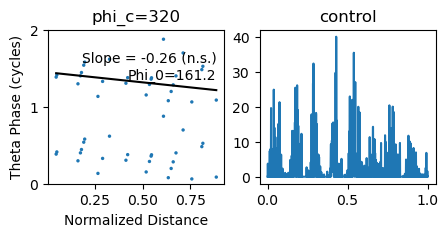

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

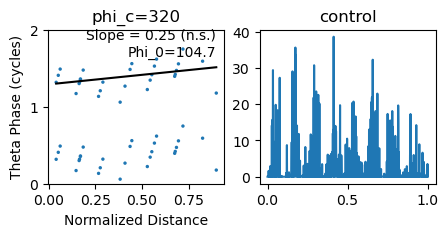

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

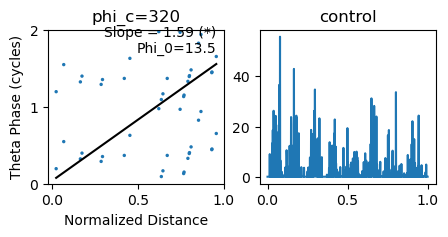

In [14]:

experiment = 'control'

for i in range(6):


    simulator, model = setup(experiment)
    
    spike_times, spike_phases, valid = simulator.simulate(n_trains, firing_rate)
    regressor = CircularLinearRegressor(spike_times[valid].unsqueeze(0),
                                        spike_phases[valid].unsqueeze(0),
                                        [-2, 2],
                                        n_optimization_steps=200,
                                        optimizer_step_size=3e-2)
    
    slope, phi_on, rho, tavl, pval, _ = regressor.regresscl()
    print(f"pvalue = {pval}")


    distance = np.c_[spike_times[valid].cpu(), spike_times[valid].cpu()]
    phase = np.c_[spike_phases[valid].cpu(), 2*pi+spike_phases[valid].cpu()]
    m, M = min(distance.ravel()), max(distance.ravel())
    # m, M = 0, 1

    _, ax = plt.subplots(1,2,figsize=(5,2))
    ax[0].scatter(distance, phase, s=6, ec='none')
    Y = place_regression_line(slope, phi_on, m, M, ax[0])
    ax[0].text(M, pi+Y[:, -1], f'Slope = {slope[-1]:.2f} ({sigstars(pval)})\nPhi_0={phi_on/pi*180:.1f}', ha='right', va='top')
    ax[0].set_title(f"phi_c={phi_control}")

    x = torch.linspace(0,1,1001) 
    drive, DG, MEC, INH = model.TotalDrive(x, return_components=True)
    ax[1].plot(x, drive)
    ax[1].set_title(experiment)

    plt.savefig(os.path.join(saveFigsTo, rf'example_{i}_-{experiment}-A={A_control}_phi={phi_control}.pdf'), bbox_inches='tight')



multi trial examples

setup, psi=-30, A=2.5, phi=320
Optimization: done 100 steps in 0.094 s.
	Forward pass: 0.042s.
	Backward pass: 0.037s.
	Param updates: 0.011s.
Optimization: done 200 steps in 0.187 s.
	Forward pass: 0.042s.
	Backward pass: 0.036s.
	Param updates: 0.011s.
pvalue = 0.0007562748191443092


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

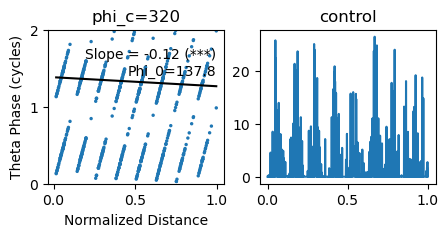

In [15]:
n_multi_trains=20

experiment = 'control'

simulator, model = setup(experiment)
    
spike_times, spike_phases, valid = simulator.simulate(n_multi_trains, firing_rate)
regressor = CircularLinearRegressor(spike_times[valid].unsqueeze(0),
                                    spike_phases[valid].unsqueeze(0),
                                    [-2, 2],
                                    n_optimization_steps=200,
                                    optimizer_step_size=3e-2)
    
slope, phi_on, rho, tavl, pval, _ = regressor.regresscl()
print(f"pvalue = {pval}")


distance = np.c_[spike_times[valid].cpu(), spike_times[valid].cpu()]
phase = np.c_[spike_phases[valid].cpu(), 2*pi+spike_phases[valid].cpu()]
m, M = min(distance.ravel()), max(distance.ravel())
# m, M = 0, 1

_, ax = plt.subplots(1,2,figsize=(5,2))
ax[0].scatter(distance, phase, s=6, ec='none')
Y = place_regression_line(slope, phi_on, m, M, ax[0])
ax[0].text(M, pi+Y[:, -1], f'Slope = {slope[-1]:.2f} ({sigstars(pval)})\nPhi_0={phi_on/pi*180:.1f}', ha='right', va='top')
ax[0].set_title(f"phi_c={phi_control}")

x = torch.linspace(0,1,1001) 
drive, DG, MEC, INH = model.TotalDrive(x, return_components=True)
ax[1].plot(x, drive)
ax[1].set_title(experiment)

plt.savefig(os.path.join(saveFigsTo, rf'example_trialaverage20_-{experiment}-A={A_control}_phi={phi_control}.pdf'), bbox_inches='tight')



single trial DG lesion examples

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


setup, psi=-30, A=2.5, phi=320
Optimization: done 100 steps in 0.047 s.
	Forward pass: 0.016s.
	Backward pass: 0.020s.
	Param updates: 0.008s.
Optimization: done 200 steps in 0.088 s.
	Forward pass: 0.014s.
	Backward pass: 0.017s.
	Param updates: 0.007s.
pvalue = 0.5920976326594433


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

setup, psi=-30, A=2.5, phi=320
Optimization: done 100 steps in 0.063 s.
	Forward pass: 0.021s.
	Backward pass: 0.026s.
	Param updates: 0.012s.
Optimization: done 200 steps in 0.103 s.
	Forward pass: 0.014s.
	Backward pass: 0.017s.
	Param updates: 0.007s.
pvalue = 0.11114497944808743


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

setup, psi=-30, A=2.5, phi=320
Optimization: done 100 steps in 0.053 s.
	Forward pass: 0.018s.
	Backward pass: 0.022s.
	Param updates: 0.010s.
Optimization: done 200 steps in 0.086 s.
	Forward pass: 0.011s.
	Backward pass: 0.014s.
	Param updates: 0.005s.
pvalue = 0.7489690788287238


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

setup, psi=-30, A=2.5, phi=320
Optimization: done 100 steps in 0.034 s.
	Forward pass: 0.011s.
	Backward pass: 0.015s.
	Param updates: 0.006s.
Optimization: done 200 steps in 0.064 s.
	Forward pass: 0.010s.
	Backward pass: 0.014s.
	Param updates: 0.005s.
pvalue = 0.3583249450336614


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

setup, psi=-30, A=2.5, phi=320
Optimization: done 100 steps in 0.047 s.
	Forward pass: 0.015s.
	Backward pass: 0.020s.
	Param updates: 0.008s.
Optimization: done 200 steps in 0.087 s.
	Forward pass: 0.013s.
	Backward pass: 0.017s.
	Param updates: 0.007s.
pvalue = 0.6323247450947124


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

setup, psi=-30, A=2.5, phi=320
Optimization: done 100 steps in 0.045 s.
	Forward pass: 0.015s.
	Backward pass: 0.019s.
	Param updates: 0.008s.
Optimization: done 200 steps in 0.081 s.
	Forward pass: 0.012s.
	Backward pass: 0.015s.
	Param updates: 0.006s.
pvalue = 0.9920160853673164


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

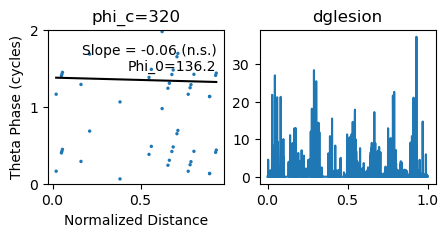

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

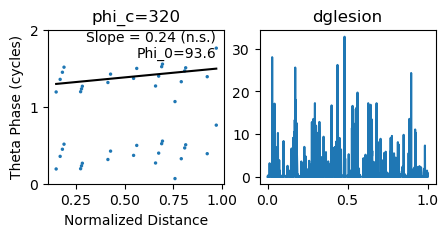

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

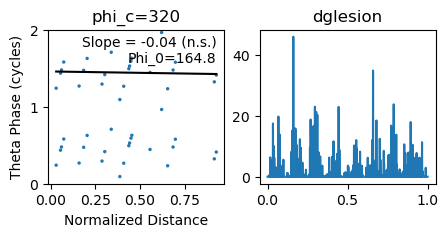

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

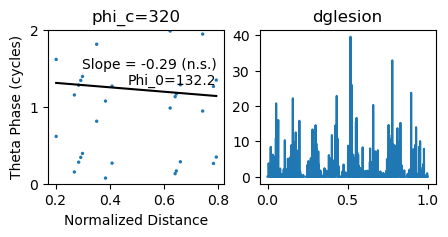

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

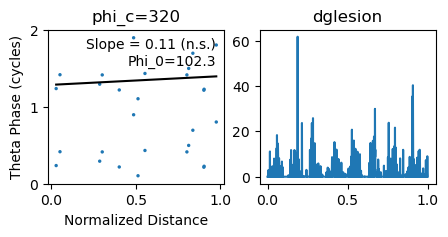

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

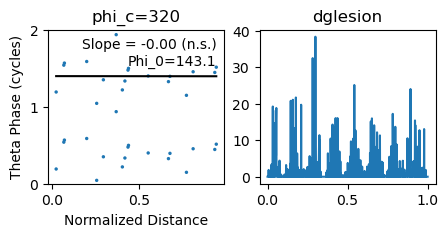

In [16]:
experiment = 'dglesion'

for i in range(6):


    simulator, model = setup(experiment)
    
    spike_times, spike_phases, valid = simulator.simulate(n_trains, firing_rate)
    regressor = CircularLinearRegressor(spike_times[valid].unsqueeze(0),
                                        spike_phases[valid].unsqueeze(0),
                                        [-2, 2],
                                        n_optimization_steps=200,
                                        optimizer_step_size=3e-2)
    
    slope, phi_on, rho, tavl, pval, _ = regressor.regresscl()
    print(f"pvalue = {pval}")


    distance = np.c_[spike_times[valid].cpu(), spike_times[valid].cpu()]
    phase = np.c_[spike_phases[valid].cpu(), 2*pi+spike_phases[valid].cpu()]
    m, M = min(distance.ravel()), max(distance.ravel())
    # m, M = 0, 1

    _, ax = plt.subplots(1,2,figsize=(5,2))
    ax[0].scatter(distance, phase, s=6, ec='none')
    Y = place_regression_line(slope, phi_on, m, M, ax[0])
    ax[0].text(M, pi+Y[:, -1], f'Slope = {slope[-1]:.2f} ({sigstars(pval)})\nPhi_0={phi_on/pi*180:.1f}', ha='right', va='top')
    ax[0].set_title(f"phi_c={phi_control}")

    x = torch.linspace(0,1,1001) 
    drive, DG, MEC, INH = model.TotalDrive(x, return_components=True)
    ax[1].plot(x, drive)
    ax[1].set_title(experiment)

    plt.savefig(os.path.join(saveFigsTo, rf'example_{i}_-{experiment}-A={A_control}_phi={phi_control}.pdf'), bbox_inches='tight')


Multitrial dg lesion example

setup, psi=-30, A=2.5, phi=320
Optimization: done 100 steps in 0.113 s.
	Forward pass: 0.052s.
	Backward pass: 0.043s.
	Param updates: 0.013s.


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


Optimization: done 200 steps in 0.205 s.
	Forward pass: 0.042s.
	Backward pass: 0.036s.
	Param updates: 0.011s.
pvalue = 0.1464362449473553


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

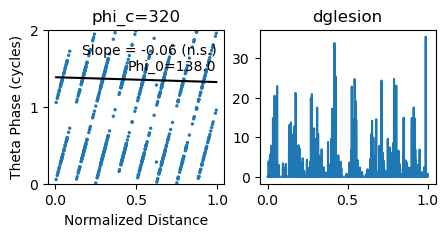

In [18]:
n_multi_trains=20
experiment = 'dglesion'


simulator, model = setup(experiment)
    
spike_times, spike_phases, valid = simulator.simulate(n_multi_trains, firing_rate)
regressor = CircularLinearRegressor(spike_times[valid].unsqueeze(0),
                                    spike_phases[valid].unsqueeze(0),
                                    [-2, 2],
                                    n_optimization_steps=200,
                                    optimizer_step_size=3e-2)
    
slope, phi_on, rho, tavl, pval, _ = regressor.regresscl()
print(f"pvalue = {pval}")


distance = np.c_[spike_times[valid].cpu(), spike_times[valid].cpu()]
phase = np.c_[spike_phases[valid].cpu(), 2*pi+spike_phases[valid].cpu()]
m, M = min(distance.ravel()), max(distance.ravel())
# m, M = 0, 1

_, ax = plt.subplots(1,2,figsize=(5,2))
ax[0].scatter(distance, phase, s=6, ec='none')
Y = place_regression_line(slope, phi_on, m, M, ax[0])
ax[0].text(M, pi+Y[:, -1], f'Slope = {slope[-1]:.2f} ({sigstars(pval)})\nPhi_0={phi_on/pi*180:.1f}', ha='right', va='top')
ax[0].set_title(f"phi_c={phi_control}")

x = torch.linspace(0,1,1001) 
drive, DG, MEC, INH = model.TotalDrive(x, return_components=True)
ax[1].plot(x, drive)
ax[1].set_title(experiment)

plt.savefig(os.path.join(saveFigsTo, rf'example_trialaverage20_-{experiment}-A={A_control}_phi={phi_control}.pdf'), bbox_inches='tight')


single trial mec lesion example

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


setup, psi=-30, A=2.5, phi=320
Optimization: done 100 steps in 0.047 s.
	Forward pass: 0.016s.
	Backward pass: 0.020s.
	Param updates: 0.008s.
Optimization: done 200 steps in 0.080 s.
	Forward pass: 0.012s.
	Backward pass: 0.015s.
	Param updates: 0.005s.
pvalue = 0.05379016074495868


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

setup, psi=-30, A=2.5, phi=320
Optimization: done 100 steps in 0.058 s.
	Forward pass: 0.019s.
	Backward pass: 0.024s.
	Param updates: 0.011s.
Optimization: done 200 steps in 0.103 s.
	Forward pass: 0.015s.
	Backward pass: 0.020s.
	Param updates: 0.008s.
pvalue = 0.12904894956179902


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

setup, psi=-30, A=2.5, phi=320
Optimization: done 100 steps in 0.041 s.
	Forward pass: 0.014s.
	Backward pass: 0.017s.
	Param updates: 0.007s.
Optimization: done 200 steps in 0.077 s.
	Forward pass: 0.013s.
	Backward pass: 0.016s.
	Param updates: 0.006s.
pvalue = 0.37799184956387066


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

setup, psi=-30, A=2.5, phi=320
Optimization: done 100 steps in 0.034 s.
	Forward pass: 0.011s.
	Backward pass: 0.015s.
	Param updates: 0.006s.
Optimization: done 200 steps in 0.071 s.
	Forward pass: 0.012s.
	Backward pass: 0.016s.
	Param updates: 0.007s.
pvalue = 0.026197242519580444


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

setup, psi=-30, A=2.5, phi=320
Optimization: done 100 steps in 0.042 s.
	Forward pass: 0.014s.
	Backward pass: 0.018s.
	Param updates: 0.007s.
Optimization: done 200 steps in 0.077 s.
	Forward pass: 0.012s.
	Backward pass: 0.015s.
	Param updates: 0.006s.
pvalue = 0.5995803389048792


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

setup, psi=-30, A=2.5, phi=320
Optimization: done 100 steps in 0.041 s.
	Forward pass: 0.014s.
	Backward pass: 0.018s.
	Param updates: 0.007s.
Optimization: done 200 steps in 0.080 s.
	Forward pass: 0.013s.
	Backward pass: 0.017s.
	Param updates: 0.007s.
pvalue = 0.3534045943730947


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

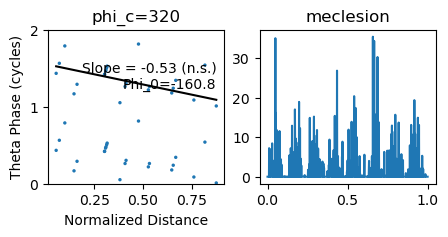

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

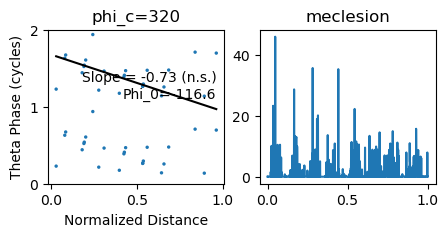

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

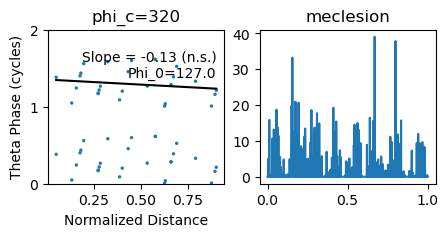

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

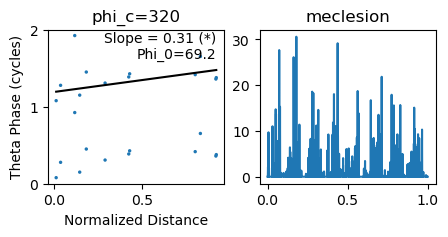

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

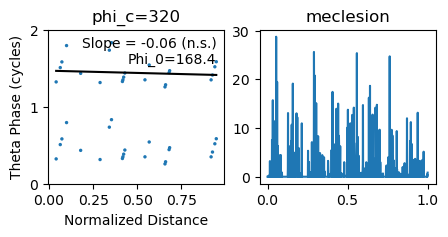

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

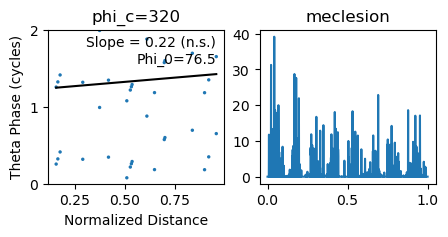

In [19]:
experiment = 'meclesion'

for i in range(6):


    simulator, model = setup(experiment)
    
    spike_times, spike_phases, valid = simulator.simulate(n_trains, firing_rate)
    regressor = CircularLinearRegressor(spike_times[valid].unsqueeze(0),
                                        spike_phases[valid].unsqueeze(0),
                                        [-2, 2],
                                        n_optimization_steps=200,
                                        optimizer_step_size=3e-2)
    
    slope, phi_on, rho, tavl, pval, _ = regressor.regresscl()
    print(f"pvalue = {pval}")


    distance = np.c_[spike_times[valid].cpu(), spike_times[valid].cpu()]
    phase = np.c_[spike_phases[valid].cpu(), 2*pi+spike_phases[valid].cpu()]
    m, M = min(distance.ravel()), max(distance.ravel())
    # m, M = 0, 1

    _, ax = plt.subplots(1,2,figsize=(5,2))
    ax[0].scatter(distance, phase, s=6, ec='none')
    Y = place_regression_line(slope, phi_on, m, M, ax[0])
    ax[0].text(M, pi+Y[:, -1], f'Slope = {slope[-1]:.2f} ({sigstars(pval)})\nPhi_0={phi_on/pi*180:.1f}', ha='right', va='top')
    ax[0].set_title(f"phi_c={phi_control}")

    x = torch.linspace(0,1,1001) 
    drive, DG, MEC, INH = model.TotalDrive(x, return_components=True)
    ax[1].plot(x, drive)
    ax[1].set_title(experiment)

    plt.savefig(os.path.join(saveFigsTo, rf'example_{i}_-{experiment}-A={A_control}_phi={phi_control}.pdf'), bbox_inches='tight')




multi trial mec lesion example

setup, psi=-30, A=2.5, phi=320
Optimization: done 100 steps in 0.103 s.
	Forward pass: 0.049s.
	Backward pass: 0.040s.
	Param updates: 0.011s.
Optimization: done 200 steps in 0.192 s.
	Forward pass: 0.041s.
	Backward pass: 0.034s.
	Param updates: 0.010s.


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


pvalue = 0.14851895664063264


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

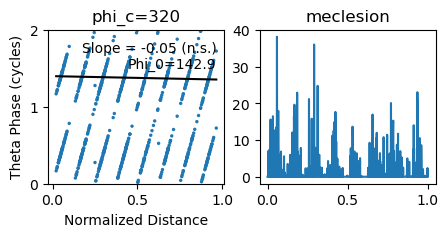

In [20]:
n_multi_trains=20

experiment = 'meclesion'

simulator, model = setup(experiment)
    
spike_times, spike_phases, valid = simulator.simulate(n_multi_trains, firing_rate)
regressor = CircularLinearRegressor(spike_times[valid].unsqueeze(0),
                                    spike_phases[valid].unsqueeze(0),
                                    [-2, 2],
                                    n_optimization_steps=200,
                                    optimizer_step_size=3e-2)
    
slope, phi_on, rho, tavl, pval, _ = regressor.regresscl()
print(f"pvalue = {pval}")


distance = np.c_[spike_times[valid].cpu(), spike_times[valid].cpu()]
phase = np.c_[spike_phases[valid].cpu(), 2*pi+spike_phases[valid].cpu()]
m, M = min(distance.ravel()), max(distance.ravel())
# m, M = 0, 1

_, ax = plt.subplots(1,2,figsize=(5,2))
ax[0].scatter(distance, phase, s=6, ec='none')
Y = place_regression_line(slope, phi_on, m, M, ax[0])
ax[0].text(M, pi+Y[:, -1], f'Slope = {slope[-1]:.2f} ({sigstars(pval)})\nPhi_0={phi_on/pi*180:.1f}', ha='right', va='top')
ax[0].set_title(f"phi_c={phi_control}")

x = torch.linspace(0,1,1001) 
drive, DG, MEC, INH = model.TotalDrive(x, return_components=True)
ax[1].plot(x, drive)
ax[1].set_title(experiment)

plt.savefig(os.path.join(saveFigsTo, rf'example_trialaverage20_-{experiment}-A={A_control}_phi={phi_control}.pdf'), bbox_inches='tight')
